Group and sum by metaprogram problem solved with: https://stackoverflow.com/questions/39650749/group-by-sparse-matrix-in-scipy-and-return-a-matrix

#### Load modules

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

import scanpy as sc
import squidpy as sq

import scipy

from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
base_directory = '/n/scratch/users/s/sad167/EPN/Xenium/'
directory = base_directory + 'analysis/5_plots'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
# import metadata
metadata = pd.read_excel(base_directory+'scripts_revisions/SampleIdentifier.xlsx')

metadata = metadata[~metadata["SampleName"].isin(["STEPN14_Region_1", "STEPN14_Region_2"])]# extract sample name and path to raw data
SampleName = metadata['SampleName'].tolist()
SampleID = metadata['Sample'].tolist()
RawDataPath = metadata['RawDataPath'].tolist()

In [4]:
print(SampleName)

['STEPN17_Region_1', 'STEPN06_Region_1', 'STEPN06_Region_2', 'STEPN06_Region_3', 'STEPN10_Region_1', 'STEPN10_Region_2', 'STEPN12_Region_1', 'STEPN12_Region_2', 'STEPN12_Region_3', 'STEPN19_Region_1', 'STEPN19_Region_2', 'STEPN16_Region_1', 'STEPN18_Region_1', 'STEPN01_Region_1', 'STEPN01_Region_2', 'STEPN01_Region_3', 'STEPN06_Region_4', 'STEPN06_Region_5', 'STEPN10_Region_3', 'STEPN12_Region_4', 'STEPN15_Region_1']


In [5]:
# color palette
metaprogram_names = ["Neuroepithelial-like", "Radial-glia-like", 
                                       "Embryonic-neuronal-like", "Neuronal-like" ,"Ependymal-like", "MES-like", 
                                       "T-cells", "Myeloid",  "Endothelial",  "Oligodendrocytes", 'Astrocyte', 'Neurons']

metaprogram_colors = ["#F99E93FF","#9E5E9BFF","#74ADD1FF",'#0F4F8B', "#ACD39EFF","#96410EFF", 
                                '#FFF087FF',  '#F47942FF', 'violetred3', '#AECEBFFF', '#30A0A4FF', '#55A19EFF']

metaprogram_to_color = dict(zip(metaprogram_names, metaprogram_colors))

anndata_list = []
for i in range(len(SampleName)):
    adata = sc.read_10x_h5(filename = base_directory + 'data/raw_data/' + RawDataPath[i]+'/cell_feature_matrix.h5')
    df = pd.read_csv(base_directory + 'data/raw_data/' + RawDataPath[i]+'/cells.csv.gz')

    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()

    adata.obsm["spatial"] = np.array([adata.obs.x_centroid*0.325, adata.obs.y_centroid*0.325]).transpose().astype('float64')
    
    # read metadata with annotations
    anno = pd.read_csv(base_directory + 'analysis/3_program_annotation/data/cell_ID_'  + SampleName[i] + '.csv', index_col = 0)

    # Replace values in the "group" column
    anno['group'].replace({'Embryonic-like': 'Neuroepithelial-like'}, inplace=True)

    #if 'X' in anno.columns:
    #    anno.index = anno['X']
    
    #adata = adata[anno.index,:]
    
    adata.obs['Metaprogram'] = anno['group']
    adata.obs['Metaprogram'] = adata.obs['Metaprogram'].astype('category')
    adata.obs['sample'] = SampleName[i]

    # Add the color information to the AnnData object
    adata.uns['Metaprogram_colors'] = metaprogram_to_color

    # remove unassigned
    adata = adata[~adata.obs['Metaprogram'].isin(['Unknown'])]

    
    anndata_list.append(adata)
    
    print(SampleName[i])

adata = sc.concat(anndata_list) 

STEPN17_Region_1
STEPN06_Region_1
STEPN06_Region_2
STEPN06_Region_3
STEPN10_Region_1
STEPN10_Region_2
STEPN12_Region_1
STEPN12_Region_2
STEPN12_Region_3
STEPN19_Region_1
STEPN19_Region_2
STEPN16_Region_1
STEPN18_Region_1
STEPN01_Region_1
STEPN01_Region_2
STEPN01_Region_3
STEPN06_Region_4
STEPN06_Region_5
STEPN10_Region_3
STEPN12_Region_4
STEPN15_Region_1


In [6]:
# Print all unique metaprograms
print(adata.obs['Metaprogram'].unique())

['Neurons', 'Neuroepithelial-like', 'Endothelial', 'Ependymal-like', 'Oligodendrocytes', ..., 'Myeloid', 'Radial-glia-like', 'Neuronal-like', 'T-cells', NaN]
Length: 11
Categories (10, object): ['Endothelial', 'Ependymal-like', 'MES-like', 'Myeloid', ..., 'Neurons', 'Oligodendrocytes', 'Radial-glia-like', 'T-cells']


### Dot plot marker genes

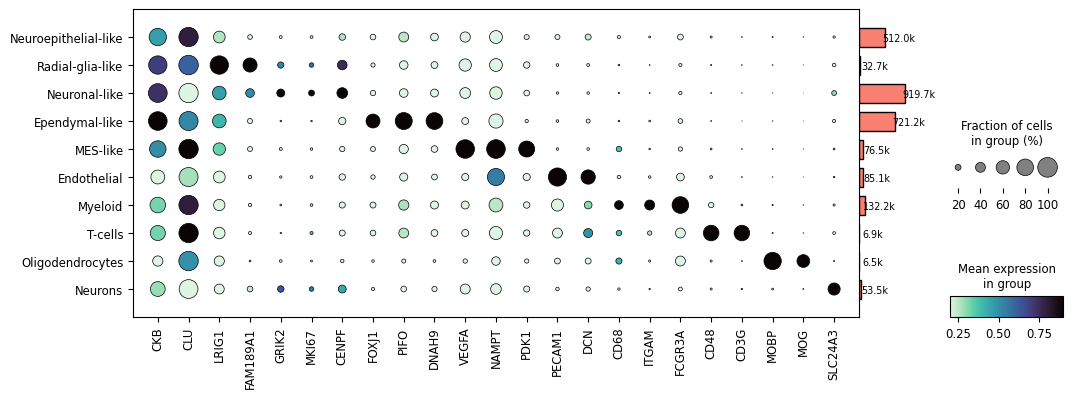

In [7]:

# color scale
cmap_reversed = plt.get_cmap('mako').reversed()

markers = ['CKB', 'CLU',  # neuroepithelial LIKE
           'LRIG1', 'FAM189A1',  # RG-LIKE
           'GRIK2', 'MKI67', 'CENPF' , #neuronal-LIKE
           'FOXJ1', 'PIFO',  'DNAH9', # ependymal-LIKE
           'VEGFA', 'NAMPT', 'PDK1', # MES-like
           'PECAM1','DCN', # ENDOTHELIAL
           'CD68', 'ITGAM', 'FCGR3A', # MYELOID
           'CD48', 'CD3G', # TCELLS
          'MOBP', 'MOG', #OLIGOS
          'SLC24A3'  # neuron
          ]


order_programs = [ "Neuroepithelial-like", "Radial-glia-like", 
                  "Neuronal-like" ,"Ependymal-like", "MES-like", 
                    "Endothelial", "Myeloid", "T-cells", 
                  "Oligodendrocytes", 'Neurons']

dp = sc.pl.dotplot(adata, markers, 'Metaprogram', 
                   figsize = (12, 4), 
                   categories_order=order_programs,
                   vmin = 0.2,
                   vmax = 0.9,
                   standard_scale = 'var',
                   return_fig = True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap=cmap_reversed)
dp.savefig(directory+"/1_dotplot_markers.pdf")

Dot plot fusion expression

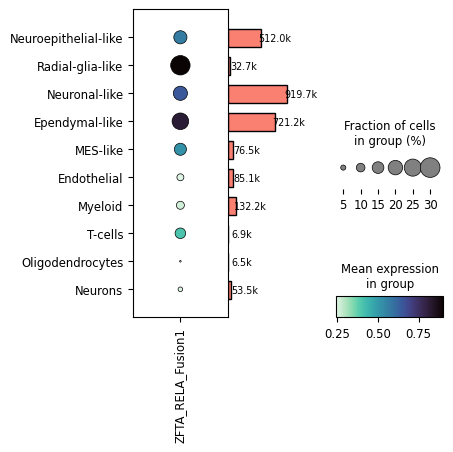

In [8]:
# color scale
cmap_reversed = plt.get_cmap('mako').reversed()

markers = ['ZFTA_RELA_Fusion1']

dp = sc.pl.dotplot(adata, markers, 'Metaprogram', 
                   figsize = (4, 4), 
                   categories_order=order_programs,
                   vmin = 0.245,
                   vmax = 0.9,
                   standard_scale = 'var',
                   return_fig = True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap=cmap_reversed)
dp.savefig(directory+"/1_dotplot_markers_ZR.pdf")

# Normalization and clustering

### Filtering

In [11]:
sc.pp.filter_cells(adata, min_counts=1)


### subset to 5000 random cells/sample

In [12]:
import numpy as np

# Ensure the index in adata.obs is unique
adata.obs = adata.obs.reset_index(drop=True)

# Define the column in adata.obs that indicates the sample
sample_column = "sample"  # Replace with your actual column name

# Create an empty list to store indices of selected cells
selected_indices = []

# Loop through each sample in the data
for sample in adata.obs[sample_column].unique():
    # Get the indices of cells belonging to the current sample
    sample_indices = adata.obs.index[adata.obs[sample_column] == sample].to_list()
    
    # Randomly select up to 10,000 cells from the sample
    if len(sample_indices) > 5000:
        sample_indices = np.random.choice(sample_indices, 5000, replace=False)
    
    # Add the selected indices to the list
    selected_indices.extend(sample_indices)

# Subset the AnnData object to the selected cells
adata_subset = adata[selected_indices, :]

print(f"Subsetted adata object to {adata_subset.shape[0]} cells.")


Subsetted adata object to 105000 cells.


In [13]:
metaprogram_names = ["Neuroepithelial-like", "Radial-glia-like", 
                                       "Embryonic-neuronal-like", "Neuronal-like" ,"Ependymal-like", "MES-like", 
                                       "T-cells", "Myeloid",  "Endothelial",  "Oligodendrocytes", 'Astrocyte', 'Neurons']

metaprogram_colors = ["#F99E93FF","#9E5E9BFF","#74ADD1FF",'#0F4F8B', "#ACD39EFF","#96410EFF", 
                                '#FFF087FF',  '#F47942FF', '#CD1076', '#AECEBFFF', '#30A0A4FF', '#55A19EFF']
metaprogram_to_color = dict(zip(metaprogram_names, metaprogram_colors))
metaprogram_to_color

{'Neuroepithelial-like': '#F99E93FF',
 'Radial-glia-like': '#9E5E9BFF',
 'Embryonic-neuronal-like': '#74ADD1FF',
 'Neuronal-like': '#0F4F8B',
 'Ependymal-like': '#ACD39EFF',
 'MES-like': '#96410EFF',
 'T-cells': '#FFF087FF',
 'Myeloid': '#F47942FF',
 'Endothelial': '#CD1076',
 'Oligodendrocytes': '#AECEBFFF',
 'Astrocyte': '#30A0A4FF',
 'Neurons': '#55A19EFF'}

In [14]:
adata_subset.layers["counts"] = adata_subset.X.copy()
sc.pp.normalize_total(adata_subset, inplace=True)
print('Normalization finished')
sc.pp.log1p(adata_subset)
print('Log1p finished')
sc.pp.pca(adata_subset)
print('PCA finished')
sc.pp.neighbors(adata_subset)
print('Neighbors finished')
sc.tl.umap(adata_subset)
print('UMAP finished')

Normalization finished
Log1p finished
PCA finished
UMAP finished


Visualize UMAP

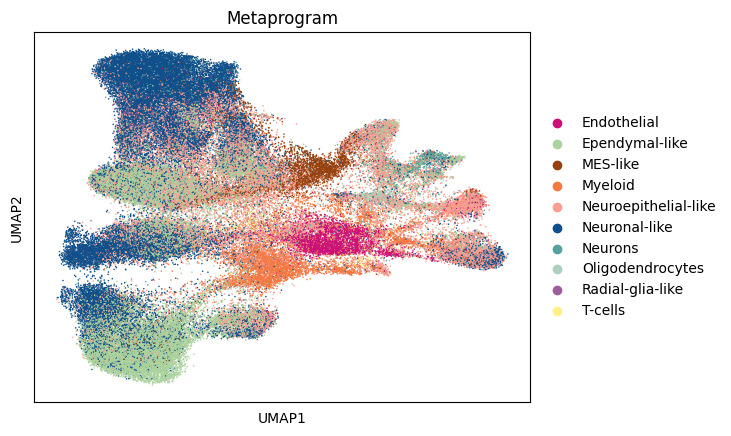

In [15]:
dp = sc.pl.umap(
    adata_subset,
    color=["Metaprogram"],
    palette = metaprogram_to_color,
    wspace=0.4,
    size = 5,
    return_fig = True
)


In [17]:
dp.set_size_inches(4, 4)
dp.savefig(directory+"/2_UMAP.pdf")

In [17]:
import matplotlib.colors as mcolors
import numpy as np

# Function to generate lighter or darker shades of a color
def generate_shades(base_color, num_shades):
    color_rgb = mcolors.to_rgb(base_color)
    shades = []
    for i in range(num_shades):
        factor = 1 + 0.2 * (i - (num_shades // 2))  # Create slight variations in brightness
        new_color = np.clip(np.array(color_rgb) * factor, 0, 1)  # Ensure the RGB values are within range
        shades.append(mcolors.to_hex(new_color))
    return shades

# Define the base colors
base_colors = ["#4E79A7FF", "#F28E2BFF", "#E15759FF", "#76B7B2FF", 
               "#59A14FFF", "#EDC948FF", "#B07AA1FF", "#FF9DA7FF", 
               "#9C755FFF"]  # Example color palette

# Define the pattern (number of times each color is repeated)
pattern = [3, 5, 3, 4, 1, 1, 1, 1, 2]

# Create the color vector
color_vector = []

for i, base_color in enumerate(base_colors):
    num_shades = pattern[i]  # Number of repetitions for each color
    shades = generate_shades(base_color, num_shades)
    color_vector.extend(shades)

# Print the resulting color vector
for color in color_vector:
    print(color)


#3e6186
#4e79a7
#5e91c8
#91551a
#c27222
#f28e2b
#ffaa34
#ffc73c
#b44647
#e15759
#ff686b
#476e6b
#5e928e
#76b7b2
#8edcd6
#59a14f
#edc948
#b07aa1
#ff9da7
#7d5e4c
#9c755f


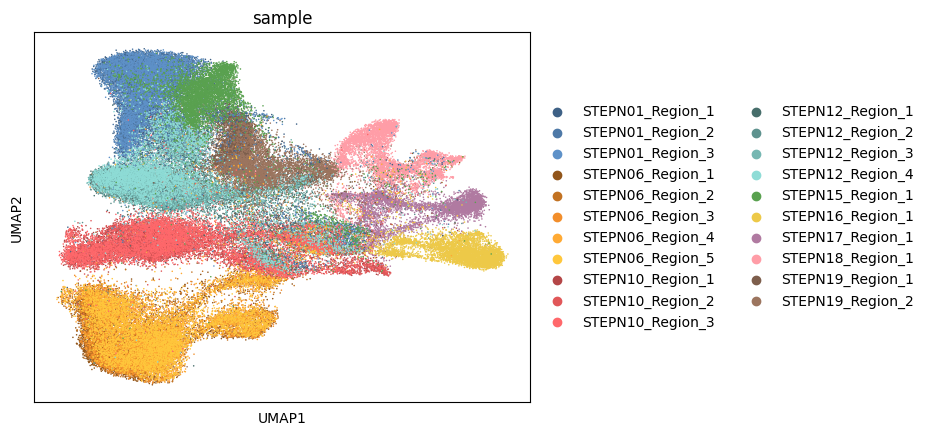

In [18]:
dp = sc.pl.umap(
    adata_subset,
    color=["sample"],
    wspace=0.4,
    palette = color_vector,
    size = 5,
    return_fig = True
)


In [19]:
dp.set_size_inches(4, 4)
dp.savefig(directory+"/2_UMAP_sample.pdf")

Differentially expressed genes

In [36]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata_subset, groupby="Metaprogram", method="wilcoxon")

In [37]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="Metaprogram", standard_scale="var", n_genes=5
)

KeyError: 'rank_genes_groups'

Dot plot fusion expression